# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [2]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [3]:
# #read in manual image dates
# manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
# manual_df = manual_df.dropna()
# manual_df.drop_duplicates(subset=['BoxID','datetimes'])
# print(manual_df.shape)
# manual_df.head()

In [4]:
# #Read in datetags csv as datetime_df
# automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
# print(automated_df.shape)
# automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [5]:
# overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
# overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
# overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
# overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
# overlap_df.shape

In [6]:
# dates = []
# for idx, row in overlap_df.iterrows():
#     dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
#     dates.append(dateID)
# # print(date_IDs)

### Select 90% for training

In [7]:
# N = len(dates); print(N)

# #pick a random sample of dates for training
# train_dates = random.sample(dates, int(N*0.9))
# print(len(train_dates))
# # print(train_dates)

# #grab remaining for testing
# test_dates = []
# for date in dates:
#     if date not in train_dates:
#         test_dates.append(date)
# print(len(test_dates))
# # print(test_dates)

# #Check that they don't overlap, should return empty
# print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [8]:
# boxes = []; imgdates = []; scenes = []

# for td in train_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# train_df.head()

In [ ]:
# #export to csv and text
# train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
# train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [ ]:
# boxes = []; imgdates = []; scenes = []

# for td in test_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# # test_df.head()
# #export to csv and text
# test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
# test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Define objective function

I'm using a modified version of the L1-norm. Imported from the automated_terminus_functions.py script. The objective funciton will be 1/N * (|Xa-Xm|i) where i=3 (for each centerline 50, 25, 75) and N equals the number of delineations generated (the more the better). The goal then is to minimize the objective function.

In [ ]:
# DOA = '2020_01_20'

# def calc_theta(size_thresh, mod_thresh):
#     #Calculate automated tpos
#     #run terminus_pick.tcl using each of the thresholds
#     terminus_pick = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/terminus_pick.tcl '+str(size_thresh)+' '+str(mod_thresh)
#     print(terminus_pick)
#     subprocess.call(terminus_pick, shell=True)
    
#     #pull automated terminus position from the output
#     #grab each output file
#     differences = []
    
#     for file in os.listdir(sg_path):
#         if DOA in file and file.endswith('csv'):
#             if len(file)>28:
#                 print(file)

#                 #read the output file in and calculate terminus position for each image
#                 #pull automated terminus delineations
#                 auto_tpos = 

#                 #pull in manual tpos 
#                 man_tpos = 

#                 diff = abs(auto_tpos - man_tpos)
#                 differences.append(diff)
    
# #     #return objective function = distance between the two
# #     return np.average(differences)

In [ ]:
# def minimize(size_guess, mod_guess):
#     minimum = scipy.optimize.fmin(center_dist, [size_guess, mod_guess], args=(size_guess, mod_guess),full_output=True)
#     xopt = minimum[0][0]
#     funcval = minimum[1]
#     return xopt, funcval

## Run the optimization

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [11]:
#import objective function
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta

In [23]:
#create the thresholds to input into the objective function
base_size_thresh = 0.71; base_mod_thresh = 0.7; base_arg_thresh = 0.47;
thresh_range = 0.05; step=0.01;
size_guesses = np.arange(base_size_thresh-thresh_range, base_size_thresh+thresh_range, step)
# mod_guesses = np.arange(base_mod_thresh-thresh_range, base_mod_thresh+thresh_range, step)
mod_guesses = [base_mod_thresh]
arg_guesses = np.arange(base_arg_thresh-0.04, base_arg_thresh+thresh_range, step)
# display the threshold guesses
print(size_guesses); print(mod_guesses); print(arg_guesses)

[0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76]
[0.7]
[0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52]


In [24]:
# create list of thresholding orders to test
# orders = ['_AMS', '_ASM', '_MAS', '_MSA', '_MSA', '_SAM', '_SMA']
orders = ['_MSA']
n_iter = len(orders)*len(size_guesses)*len(mod_guesses)*len(arg_guesses)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

110 iterations
36.666666666666664 max hours to run


In [25]:
type(" ".join(['001', '002', '120', '174', '259']))

str

### Hard-coded:

In [26]:
import subprocess
import pandas as pd; import numpy as np
import time

# BoxIDs = " ".join(['001', '002', '120', '174', '259']); print(IDs)
start_time = time.time() #start recording time

slist = []; mlist = []; alist = []; orderlist = []; thetalist = []; runtimes = []; #store run results

iter_count = 0
for order in orders:
    for s in size_guesses:
        for m in mod_guesses:
            for a in arg_guesses:
                t0 = time.time() # start recording time for each run
                # make sure precision and format is correct for the thresholds
                s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); a = float("{0:.3f}".format(a));
                print(order[1:4], s, m, a)
                #append the thresholds and order to lists
                slist.append(s); mlist.append(m); alist.append(a); orderlist.append(order[1:4]) 
                
                #run objective function calculation
                theta = objective_func(s, m, a, order); print(theta); thetalist.append(theta)

                runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
                print("Iteration run time: %s seconds " % runtime) #print run time for each iteration
                
                iter_count = iter_count+1
                print("Progress: "+str(iter_count/n_iter*100)+" %")
        
print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

MSA 0.66 0.7 0.43
25.551723948907316
Iteration run time: 643.9551441669464 seconds 
MSA 0.66 0.7 0.44
25.308365844677095
Iteration run time: 626.4382264614105 seconds 
MSA 0.66 0.7 0.45
25.13205655332633
Iteration run time: 610.0934209823608 seconds 
MSA 0.66 0.7 0.46
24.721423090417694
Iteration run time: 604.1008925437927 seconds 
MSA 0.66 0.7 0.47
24.924107517499817
Iteration run time: 597.3067572116852 seconds 
MSA 0.66 0.7 0.48
24.82763257286036
Iteration run time: 581.2807705402374 seconds 
MSA 0.66 0.7 0.49
25.319085864260206
Iteration run time: 575.3039283752441 seconds 
MSA 0.66 0.7 0.5
25.069900512209546
Iteration run time: 568.2819290161133 seconds 
MSA 0.66 0.7 0.51
25.347046318825242
Iteration run time: 563.874801158905 seconds 
MSA 0.66 0.7 0.52
25.771501855557062
Iteration run time: 554.6377604007721 seconds 
MSA 0.67 0.7 0.43
25.443191801634367
Iteration run time: 645.9376864433289 seconds 
MSA 0.67 0.7 0.44
25.2126205976969
Iteration run time: 627.6476509571075 seconds

25.69874500351876
Iteration run time: 570.5838685035706 seconds 
MSA 0.76 0.7 0.43
25.771973516813993
Iteration run time: 657.0004642009735 seconds 
MSA 0.76 0.7 0.44
25.376100655405697
Iteration run time: 647.9230270385742 seconds 
MSA 0.76 0.7 0.45
25.28579742392666
Iteration run time: 627.0040929317474 seconds 
MSA 0.76 0.7 0.46
25.33566415500642
Iteration run time: 618.2947359085083 seconds 
MSA 0.76 0.7 0.47
25.41123580633766
Iteration run time: 606.0215201377869 seconds 
MSA 0.76 0.7 0.48
25.77361781470692
Iteration run time: 598.3739364147186 seconds 
MSA 0.76 0.7 0.49
26.01263203007452
Iteration run time: 590.4040386676788 seconds 
MSA 0.76 0.7 0.5
26.007157194253626
Iteration run time: 586.8284566402435 seconds 
MSA 0.76 0.7 0.51
26.155698730055597
Iteration run time: 579.9365451335907 seconds 
MSA 0.76 0.7 0.52
25.958109318969356
Iteration run time: 569.7394852638245 seconds 
Total time elapsed: --- 65887.61602044106 seconds ---


In [27]:
optimization_df = pd.DataFrame(list(zip(thetalist, orderlist, slist, mlist, alist, runtimes)), 
                               columns=['Theta', 'Order', 'Size_thresh', 'Mod_thresh', 'Arg_thresh','run_time'])
optimization_df

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,25.551724,MSA,0.66,0.7,0.43,643.955144
1,25.308366,MSA,0.66,0.7,0.44,626.438226
2,25.132057,MSA,0.66,0.7,0.45,610.093421
3,24.721423,MSA,0.66,0.7,0.46,604.100893
4,24.924108,MSA,0.66,0.7,0.47,597.306757
5,24.827633,MSA,0.66,0.7,0.48,581.280771
6,25.319086,MSA,0.66,0.7,0.49,575.303928
7,25.069901,MSA,0.66,0.7,0.50,568.281929
8,25.347046,MSA,0.66,0.7,0.51,563.874801
9,25.771502,MSA,0.66,0.7,0.52,554.637760


In [28]:
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
53,24.601646,MSA,0.71,0.7,0.46,605.671272


In [29]:
optimization_df.to_csv(sg_path+'optimizationresults_SA_3.csv', sep=',')

# Visualize optimization results

Results from calculating mistfits between automated and manual delineations based on different thresholds used for filtering the WTMM lines. The two thresholds shown here are the size (length) threshold and the mod (gradient value) threshold, which are percentages of the maximum size/mod. So ideally, for 1 parameter (one threshold), the results should look like a parabola. For two 2 parameters like used here, one can visualize it in 3D. 

In [33]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

#activate interactive widgets for plots:
%matplotlib notebook

path = '/Users/julialiu/Documents/BSU/EGG/'

In [37]:
# df1 = pd.read_csv(sg_path+'optimizationresults_order.csv', sep=',')
# df2 = pd.read_csv(sg_path+'optimizationresults_order2.csv', sep=',')
# df3 = pd.read_csv(sg_path+'optimizationresults_1.csv', sep=',')
# df4 = pd.read_csv(sg_path+'optimizationresults_4.csv', sep=',')
# optimization_df = pd.concat([df1, df2, df3, df4])
# optimization_df = pd.concat([df1, df2])
optimization_df = pd.read_csv(sg_path+'optimizationresults_SA.csv', sep=',')

In [39]:
# optimization_df

In [ ]:
# optimization_df.to_csv(sg_path+'optimizationresults_all4.csv', sep=',')

Separate by Order

In [5]:
order = 'MSA'
order_df = optimization_df[optimization_df['Order']==order]
# order_df

x = order_df['Size_thresh']
y = order_df['Mod_thresh']
z = order_df['Arg_thresh']
theta = order_df['Theta']


<IPython.core.display.Javascript object>


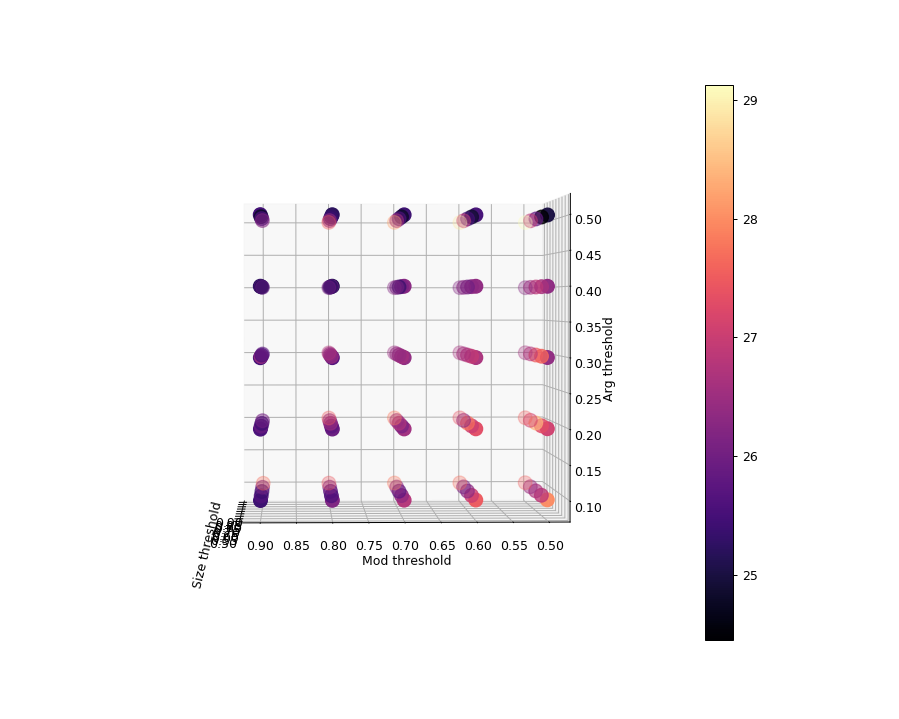

In [8]:
# 3 parameters
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

# ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
plot = ax.scatter(x,y,z, marker='o', s=120, c=theta, cmap='magma') # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle
fig.colorbar(plot)

ax.set_xlabel('Size threshold')
ax.set_ylabel('Mod threshold')
ax.set_zlabel('Arg threshold')
plt.show()

In [41]:
x = optimization_df['Size_thresh']
y = optimization_df['Arg_thresh']
z = optimization_df['Theta']

# x = order_df['Size_thresh']
# y = order_df['Arg_thresh']
# z = order_df['Theta']


<IPython.core.display.Javascript object>


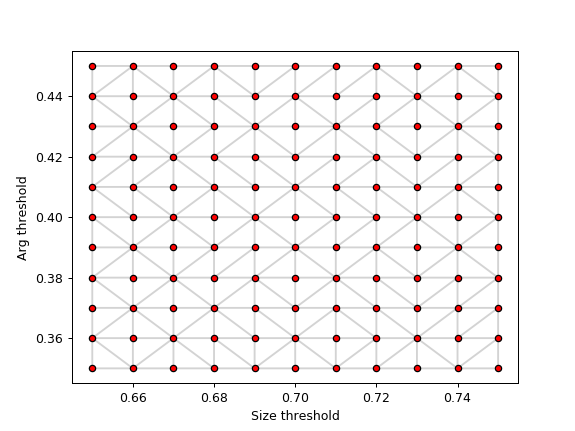

In [42]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="r", markeredgecolor="black", markersize=10)
ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
plt.show()

<IPython.core.display.Javascript object>


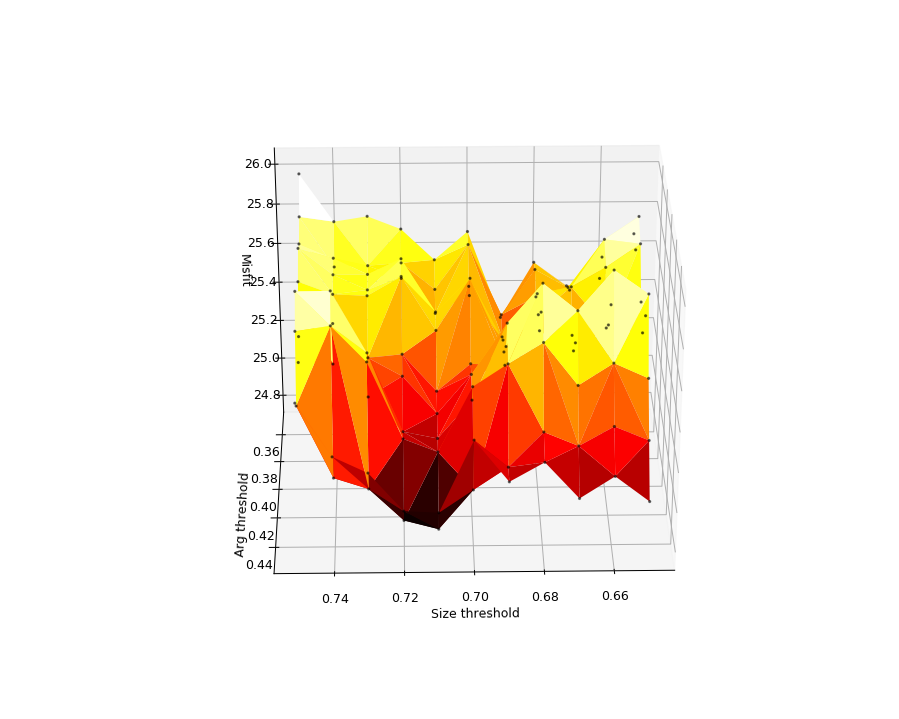

In [43]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
ax.scatter(x,y,z, marker='.', s=10, c="k", alpha=0.5) # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle

ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
ax.set_zlabel('Misfit')
plt.show()

In [44]:
# # order boxplot

# import seaborn as sns

# plt.figure(figsize=(10,8))
# sns.set_style('darkgrid')
# ax = sns.boxplot(x = 'Order', y = 'Theta', data=optimization_df)
# plt.ylabel('Misfit', fontsize=16); plt.xlabel('Filtering Order', fontsize=16)
# plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# plt.savefig(sg_path+'Misfit_by_order.png', dpi=200)
# plt.show()

Contour plot

In [45]:
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [47]:
import sys
!{sys.executable} -m pip install plotly

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f7c1ec5a6d8>: Failed to establish a new connection: [Errno -2] Name or service not known')': /simple/plotly/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f7c1ec5a8d0>: Failed to establish a new connection: [Errno -2] Name or service not known')': /simple/plotly/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f7c1ec5a438>: Failed to establish a new connection: [Errno -2] Name or service not known')': /simple/plotly/
^C


## Cross-validation